In [1]:
%matplotlib inline

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import TensorBoard
import numpy as np
import pickle
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras import models
from matplotlib import pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

In [2]:
RUN_ON_MNIST = True
L = 4

In [3]:
CHECKPOINTER = ModelCheckpoint(filepath='model_checkpoit.hdf5', 
                               monitor='val_loss',
                               verbose=1, 
                               save_best_only=True,
                               mode='auto')

# Notes:
* Add `Input` argument `channels_first` when using Z3 data and 
  change the input dimensions.
* You will have to manualy add periodic edges for periodic padding before real runn
* **requires** running the transform notebook to get the data into a format for the auto encoder

In [4]:
if RUN_ON_MNIST:
    input_obj = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_obj)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  

else:
    input_obj = Input(shape=(L*2, L*2, 1))
    x = Conv2D(16, (3, 3), strides=2, activation='relu', padding='same', use_bias=True)(input_obj)
    encoded = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same', use_bias=True)(x)
    x = Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same', use_bias=True)(encoded)
    decoded = Conv2DTranspose(1, (3, 3), strides=2, activation='relu', padding='same', use_bias=True)(x)

autoencoder = Model(input_obj, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [6]:
if RUN_ON_MNIST:
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
else:
    with open('pickle_data.pkl', 'rb') as f:
        all_data = pickle.load(f)
    all_data = all_data.astype('float32') / 5.0
    n_records = len(all_data)
    x_train = all_data[: n_records - int(n_records/4)]
    x_test = all_data[int(n_records/4) :]
    x_train = np.reshape(x_train, (len(x_train), L * 2, L * 2, 1))
    x_test = np.reshape(x_test, (len(x_test), L * 2, L * 2, 1))

In [7]:
x_train.shape

(60000, 28, 28, 1)

In [8]:
history = autoencoder.fit(
    x_train[: 20000], x_train[: 20000],
    epochs=20,
    batch_size=50,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[
        TensorBoard(log_dir='/tmp/autoencoder/{}'.format(datetime.now())),
        CHECKPOINTER
    ]
)

Epoch 1/20
399/400 [============================>.] - ETA: 0s - loss: 0.6989
Epoch 00001: val_loss improved from inf to 0.69734, saving model to model_checkpoit.hdf5
400/400 [==============================] - 11s 27ms/step - loss: 0.6989 - val_loss: 0.6973
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.6958
Epoch 00002: val_loss improved from 0.69734 to 0.69406, saving model to model_checkpoit.hdf5
400/400 [==============================] - 11s 27ms/step - loss: 0.6958 - val_loss: 0.6941
Epoch 3/20
399/400 [============================>.] - ETA: 0s - loss: 0.6923
Epoch 00003: val_loss improved from 0.69406 to 0.69017, saving model to model_checkpoit.hdf5
400/400 [==============================] - 11s 26ms/step - loss: 0.6923 - val_loss: 0.6902
Epoch 4/20
398/400 [============================>.] - ETA: 0s - loss: 0.6877
Epoch 00004: val_loss improved from 0.69017 to 0.68473, saving model to model_checkpoit.hdf5
400/400 [==============================] - 10s 24ms

In [9]:
for key in history.history:
    print(key)

loss
val_loss


In [10]:
autoencoder.load_weights('model_checkpoit.hdf5')

In [11]:
autoencoder.save('models/best_non_hparam_autoencoder.h5')

# Make a specific model for the activation tensors 

In [12]:
layers_to_encoded = int(len(autoencoder.layers)/2)

In [13]:
autoencoder.layers

In [14]:
layer_activations = [layer.output for layer in autoencoder.layers[:layers_to_encoded]]

In [15]:
activation_model = models.Model(
    inputs=autoencoder.input,
    outputs=layer_activations
)

In [16]:
x_test.shape

(10000, 28, 28, 1)

In [17]:
single_image = x_test[20]
activations = activation_model.predict(x_test[:50])

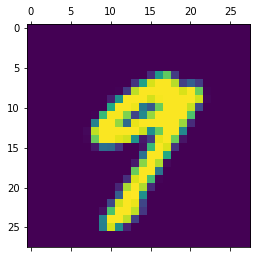

In [18]:
plt.matshow(single_image[:, :, 0])

In [19]:
len(activations)

7

In [44]:
first_layer_activation = activations[0]

In [45]:
first_layer_activation.shape

(50, 28, 28, 1)

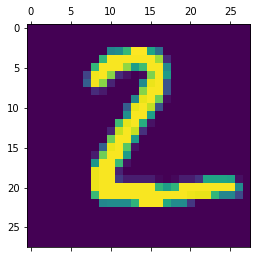

In [46]:
plt.matshow(first_layer_activation[1, :, :, 0], cmap='viridis')

In [47]:
def get_current_layer_display_grid_size(images_per_row, matrix_in):
    print(f'Layer shape {matrix_in.shape}')
    # Number of features in the feature map
    n_features = matrix_in.shape[-1]
    print(f'n_features {n_features}')
    # The feature map has shape (1, size, size, n_features).
    size = matrix_in.shape[1]
    print(f'size {size}')
    # Tiles the activation channels in this matrix
    n_cols = max([n_features // images_per_row, 1])
    print(f'n_cols {n_cols}')
    
    return size, n_cols, (size * n_cols, min(images_per_row, n_features) * size)

In [59]:
def fill_display_grid(to_fill, cur_image, cur_col, cur_row, cur_size):
    """Will modify data in reference ``to_fill``"""
    cur_image -= cur_image.mean() # Post-processes the feature to make it visually palatable
    cur_image /= cur_image.std()
    cur_image *= 64
    cur_image += 128
    cur_image = np.clip(cur_image, 0, 255).astype('uint8')
    print(f'cur_col * cur_size {cur_col * cur_size}')
    print(f'(cur_col + 1) * cur_size {(cur_col + 1) * cur_size}')
    print(f'cur_row * cur_size {cur_row * cur_size }')
    print(f'(cur_row + 1) * cur_size {(cur_row + 1) * cur_size}')
    print(f'cur_image.shape {cur_image.shape}')
    try:
        to_fill[
            cur_col * cur_size : (cur_col + 1) * cur_size, # Displays the grid
            cur_row * cur_size : (cur_row + 1) * cur_size
        ] = cur_image
    except ValueError:
        to_fill[
            cur_col * cur_size : (cur_col + 1) * cur_size, # Displays the grid
            cur_row * cur_size : (cur_row + 1) * cur_size
        ] = cur_image       

In [60]:
images_per_row = 16
layer_names = []
for layer in autoencoder.layers[:layers_to_encoded]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

Layer shape (50, 28, 28, 16)
n_features 16
size 28
n_cols 1
cur_col * cur_size 0
(cur_col + 1) * cur_size 28
cur_row * cur_size 0
(cur_row + 1) * cur_size 28
cur_image.shape (28, 28)
cur_col * cur_size 0
(cur_col + 1) * cur_size 28
cur_row * cur_size 28
(cur_row + 1) * cur_size 56
cur_image.shape (28, 28)
cur_col * cur_size 0
(cur_col + 1) * cur_size 28
cur_row * cur_size 56
(cur_row + 1) * cur_size 84
cur_image.shape (28, 28)
cur_col * cur_size 0
(cur_col + 1) * cur_size 28
cur_row * cur_size 84
(cur_row + 1) * cur_size 112
cur_image.shape (28, 28)
cur_col * cur_size 0
(cur_col + 1) * cur_size 28
cur_row * cur_size 112
(cur_row + 1) * cur_size 140
cur_image.shape (28, 28)
cur_col * cur_size 0
(cur_col + 1) * cur_size 28
cur_row * cur_size 140
(cur_row + 1) * cur_size 168
cur_image.shape (28, 28)
cur_col * cur_size 0
(cur_col + 1) * cur_size 28
cur_row * cur_size 168
(cur_row + 1) * cur_size 196
cur_image.shape (28, 28)
cur_col * cur_size 0
(cur_col + 1) * cur_size 28
cur_row * cur_siz

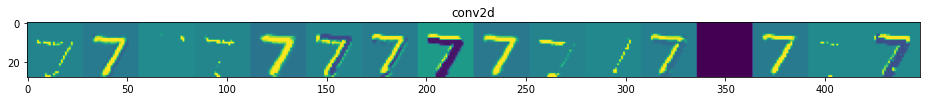

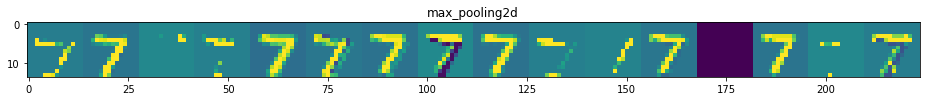

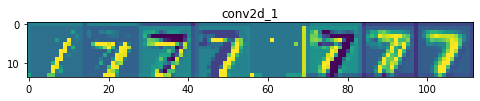

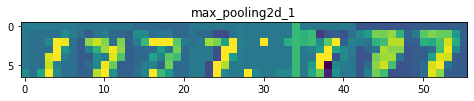

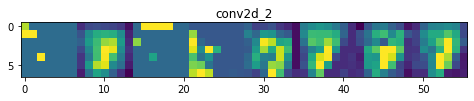

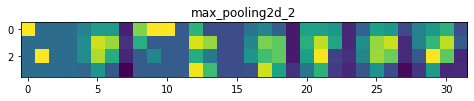

In [61]:
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    if 'input' in layer_name:
        continue
    size, n_cols, grid_dimensions = get_current_layer_display_grid_size(images_per_row, layer_activation)
    display_grid = np.zeros(grid_dimensions)
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            try:
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
            except IndexError:
                continue
            fill_display_grid(display_grid, channel_image, col, row, size)
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [72]:
def get_plottable_weights(raw_weights_from_get_layer):
    # short name
    w = raw_weights_from_get_layer
    print('in w.shape')
    print(w.shape)
    if len(w.shape) != 4:
        raise ValueError('Unexpected shape of weights')
    #w = w.reshape((w.shape[0], w.shape[1], w.shape[2]*w.shape[3])) 
    #print('shape after reshape')
    #print(w.shape)
    return w

input_1
conv2d
in w.shape
(3, 3, 1, 16)
Layer shape (3, 3, 1, 16)
n_features 16
size 3
n_cols 1
display_grid shape (3, 48)
col 0
row 0
cur_col * cur_size 0
(cur_col + 1) * cur_size 3
cur_row * cur_size 0
(cur_row + 1) * cur_size 3
cur_image.shape (3, 3)
col 0
row 1
cur_col * cur_size 0
(cur_col + 1) * cur_size 3
cur_row * cur_size 3
(cur_row + 1) * cur_size 6
cur_image.shape (3, 3)
col 0
row 2
cur_col * cur_size 0
(cur_col + 1) * cur_size 3
cur_row * cur_size 6
(cur_row + 1) * cur_size 9
cur_image.shape (3, 3)
col 0
row 3
cur_col * cur_size 0
(cur_col + 1) * cur_size 3
cur_row * cur_size 9
(cur_row + 1) * cur_size 12
cur_image.shape (3, 3)
col 0
row 4
cur_col * cur_size 0
(cur_col + 1) * cur_size 3
cur_row * cur_size 12
(cur_row + 1) * cur_size 15
cur_image.shape (3, 3)
col 0
row 5
cur_col * cur_size 0
(cur_col + 1) * cur_size 3
cur_row * cur_size 15
(cur_row + 1) * cur_size 18
cur_image.shape (3, 3)
col 0
row 6
cur_col * cur_size 0
(cur_col + 1) * cur_size 3
cur_row * cur_size 18
(cur

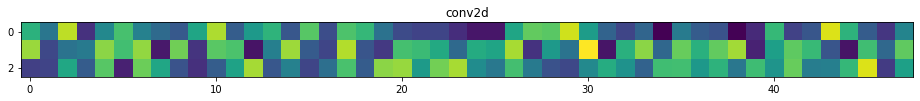

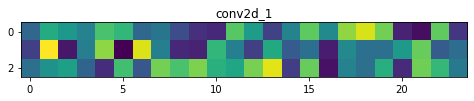

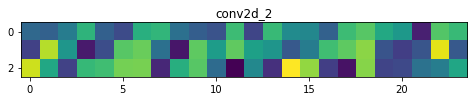

In [73]:
neuron = 0
for layer_name in layer_names:
    print(layer_name)
    if 'conv2d' not in layer_name:
        continue
    
    weights = autoencoder.get_layer(name=layer_name).get_weights()[0]
    for_plot = get_plottable_weights(weights)
    
    
    size, n_cols, grid_dimensions = get_current_layer_display_grid_size(images_per_row, for_plot)
    display_grid = np.zeros(grid_dimensions)
    print(f'display_grid shape {display_grid.shape}')
    for col in range(n_cols):
        for row in range(images_per_row):
            try:
                channel_image = for_plot[:, :, neuron, col * images_per_row + row]
            except IndexError:
                continue
            print(f'col {col}')
            print(f'row {row}')
            fill_display_grid(display_grid, channel_image, col, row, size)

    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')